### 1.Скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention

In [1]:
%matplotlib inline

import pandas as pd; pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split
import numpy as np

/home/mr-rider/snap/jupyter/common/lib/python3.7/site-packages/joblib/_multiprocessing_helpers.py:45: UserWarning: [Errno 13] Permission denied.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


In [2]:
df_data = pd.read_csv('./data.csv')

In [3]:
df_data.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [4]:
df_data.describe()

,recency,history,used_discount,used_bogo,is_referral,conversion
count,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
mean,5.763734,242.085656,0.551031,0.549719,0.502250,0.146781
std,3.507592,256.158608,0.497393,0.497526,0.499999,0.353890
min,1.000000,29.990000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,64.660000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,158.110000,1.000000,1.000000,1.000000,0.000000
75%,9.000000,325.657500,1.000000,1.000000,1.000000,0.000000
max,12.000000,3345.930000,1.000000,1.000000,1.000000,1.000000


In [5]:
df_data.describe(include=np.object)

,zip_code,channel,offer
count,64000,64000,64000
unique,3,3,3
top,Surburban,Web,Buy One Get One
freq,28776,28217,21387


### 2. Там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.

In [6]:
df_data = df_data.rename(columns={'conversion': 'target'})
df_data = df_data.rename(columns={'offer': 'treatment'})

In [7]:
df_data['treatment'].unique()

array(['Buy One Get One', 'No Offer', 'Discount'], dtype=object)

In [8]:
df_data.treatment = df_data.treatment.map({'No Offer': 0, 'Buy One Get One': 1, 'Discount': 1})

In [9]:
df_data['treatment'].value_counts()

1    42694
0    21306
Name: treatment, dtype: int64

### 3.Cделать разбиение набора данных не тренировочную и тестовую выборки

In [10]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df_data.drop('target', 1), 
                                                    df_data['target'], test_size = 0.3, random_state=42, stratify=df_data['treatment'])

### 4.Cделать feature engineering на ваше усмотрение (допускается свобода выбора методов)

In [11]:
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

In [12]:
X_train.head()

,recency,history,used_discount,used_bogo,is_referral,treatment,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
39508,4,29.99,0,1,0,0,0,1,0,0,0,1
26772,2,238.09,1,1,1,1,0,1,0,0,0,1
10416,11,93.23,0,1,1,1,0,0,1,0,1,0
57856,1,1245.43,1,1,1,1,0,0,1,0,1,0
63429,3,245.78,1,0,1,0,0,0,1,0,1,0


### 5. Провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями

#### a) одна модель с признаком коммуникации (S learner)

In [13]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

# sklift поддерживает любые модели, 
# которые удовлетворяют соглашениями scikit-learn
# Для примера воспользуемся catboost
from catboost import CatBoostClassifier

In [15]:
#cat_features = ['zip_code','channel']

In [46]:
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, X_train['treatment'])#, estimator_fit_params={'cat_features': cat_features})
uplift_sm = sm.predict(X_test)


In [47]:
models_results = {
    'approach': [],
    'uplift@30%': [],
    'uplift@20%': [],
    'uplift@10%': []
}

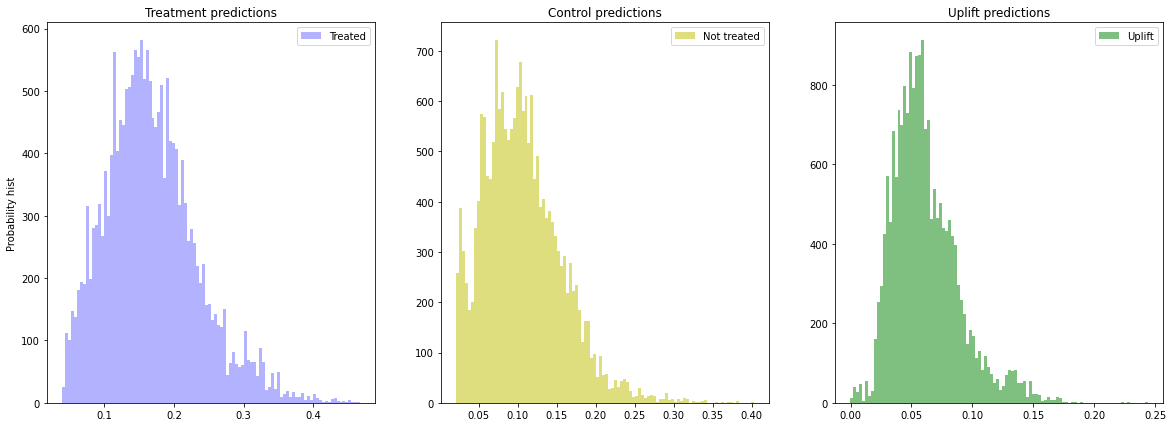

In [48]:
sm_score_30 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=X_test['treatment'], strategy='by_group', k=0.3)


models_results['approach'].append('SoloModel')
models_results['uplift@30%'].append(sm_score_30)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [49]:
sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=X_test['treatment'], strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=X_test['treatment'], strategy='by_group', k=0.2)

In [50]:
models_results['uplift@20%'].append(sm_score_20)
models_results['uplift@10%'].append(sm_score_10)

#### б) модель с трансформацией таргета (трансформация классов п. 2. 1)

In [51]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, X_train['treatment'])#, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_test)

ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=X_test['treatment'], strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=X_test['treatment'], strategy='by_group', k=0.2)
ct_score_30 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=X_test['treatment'], strategy='by_group', k=0.3)

models_results['approach'].append('ClassTransformation')
models_results['uplift@30%'].append(ct_score_30)
models_results['uplift@20%'].append(ct_score_20)
models_results['uplift@10%'].append(ct_score_10)

/snap/jupyter/6/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  """


### в) вариант с двумя независимыми моделями


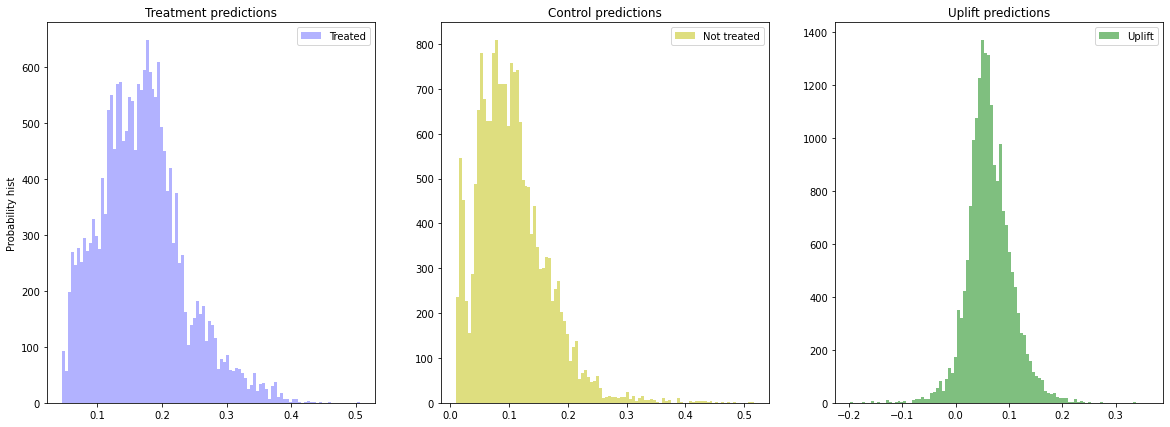

In [52]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, X_train['treatment'],
    #estimator_trmnt_fit_params={'cat_features': cat_features}, 
    #estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_test)

tm_score = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=X_test['treatment'], strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels')
models_results['uplift@30%'].append(tm_score)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [53]:
tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=X_test['treatment'], strategy='by_group', k=0.1)
tm_score_20= uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=X_test['treatment'], strategy='by_group', k=0.2)


In [54]:
models_results['uplift@10%'].append(tm_score_10)
models_results['uplift@20%'].append(tm_score_20)

### 6. В конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей

In [55]:
pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending=False)

,approach,uplift@30%,uplift@20%,uplift@10%
1,ClassTransformation,0.186004,0.211564,0.256213
0,SoloModel,0.066332,0.071540,0.095056
2,TwoModels,0.054891,0.044593,0.033305


### 7. Построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево

In [56]:
features = [col for col in X_train]

In [57]:
%%time
from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_model = UpliftTreeClassifier(max_depth=8, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train,
                 treatment=X_train['treatment'].map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
Image(graph.create_png())

ModuleNotFoundError: No module named 'causalml'